<a href="https://colab.research.google.com/github/sg2083/vis/blob/main/data_viz_ps5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Analyzing Global Food Prices, Inflation Trends, and Economic Vulnerability**

#### **Abstract**

Food prices and inflation are two critical economic indicators that shape global markets, policymaking, and household consumption. Over recent decades, food prices have exhibited significant volatility, influenced by climate change, supply chain disruptions, geopolitical events, and economic policies. This project seeks to explore the relationship between food price inflation and general inflation trends, providing insights that can assist governments, businesses, and consumers in making informed decisions on food security and economic stability.

To achieve this, datasets have been integrated from multiple global sources, including the Food and Agriculture Organization (FAO) and the World Bank.

#### **Key Research Questions**

1. How do food price indices (both nominal and real) correlate with general inflation rates?
2. What are the trends and patterns in food price fluctuations across different food categories?
3. Can we identify historical periods of high food price inflation, and what economic factors contributed to these trends?

#### **Hypotheses**

- **H1:** There is a positive correlation between food price indices and general inflation.
- **H2:** Inflation-adjusted food prices (real FPI) show less volatility than nominal food prices.
- **H3:** Different food categories (meat, dairy, cereals, oils, sugars) exhibit distinct inflationary trends based on global economic conditions.

### **Data Sources & Variables**

The following three datasets, sourced from different platforms, have been integrated and uploaded to the GitHub repository, from which they will be accessed for analysis.

1. **[Food Price Index (FPI) Data (FAO)](https://www.fao.org/worldfoodsituation/FoodPricesIndex/en/)** – Includes annual indices for food prices and subcategories (cereals, dairy, etc.), capturing both nominal and real values.
   - **URL:** [FAO FPI Data](https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/food_price_indices_data.xlsx)
   - **Key Variables:** Year, Food Price Index, Meat, Dairy, Cereals, Oils, Sugars
2. **[World Bank Inflation Data](https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG)** – Provides annual CPI-based inflation rates for multiple countries, aggregated into a global average.
   - **URL:** [World Bank Inflation Data](https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/inflation_cpi_data.csv)
   - **Key Variables:** Year, Inflation Rate
3. **[Nominal vs Real Food Price Index (FAO)](https://www.fao.org/worldfoodsituation/FoodPricesIndex/en/)** – Differentiates between nominal and inflation-adjusted food price indices.
   - **URL:** [FAO Nominal vs Real FPI Data](https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/FPI_nominal_vs_real.json)
   - **Key Variables:** Year, Nominal Index, Real Index

The Literature Review for this topic.
https://www.emerald.com/insight/content/doi/10.1108/bfj-05-2024-0428/full/html
where the study of food prices have been studied

In [ ]:
!pip install fuzzywuzzy
!pip install pandas numpy matplotlib seaborn plotly geopandas scikit-learn statsmodels prophet textblob streamlit

In [ ]:
import pandas as pd
import numpy as np
import json
import requests
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os, zipfile
import geopandas as gpd
from shapely.geometry import Point
from fuzzywuzzy import process
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
from plotly.subplots import make_subplots


In [ ]:
# Load the datasets
fpi_url = "https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/food_price_indices_data.xlsx"
inflation_url = "https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/inflation_cpi_data.csv"
nominal_real_fpi_url = "https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/FPI_nominal_vs_real.json"
GDP_url =  "https://raw.githubusercontent.com/sg2083/vis/refs/heads/main/GDP.csv"

fpi_data = pd.read_excel(fpi_url, sheet_name="Annual", skiprows=1, engine="openpyxl")
food_inflation_data = pd.read_csv(inflation_url, skiprows=4)
GDP_over_the_years = pd.read_csv(GDP_url)
response = requests.get(nominal_real_fpi_url) # fetch the data from the URL
nominal_real_fpi_data = json.loads(response.text)  # load the JSON data from the response

nominal_real_fpi_df = pd.DataFrame(nominal_real_fpi_data['FFPI_Historical'])


### **Data Processing Steps**

#### **1. Data Cleaning and Transformation**

- **Renamed Variables**: Standardized column names across datasets for consistency.
- **Dropped Irrelevant Columns**: Retained only necessary columns such as Year, Inflation Rate, and Food Price Indices.
- **Replaced Values**: Forward-filled missing inflation rates where necessary.
- **Reshaped Data**: Converted World Bank inflation data from wide to long format.

In [ ]:
#Reshaped DATA
food_inflation_data = pd.melt(food_inflation_data, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                        var_name='Year', value_name='Inflation Rate')

# Display the first few rows of the reshaped inflation data
print(food_inflation_data.head())


                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                          Indicator Name  Indicator Code  Year  Inflation Rate  
0  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG  1960             NaN  
1  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG  1960             NaN  
2  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG  1960             NaN  
3  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG  1960             NaN  
4  Inflation, consumer prices (annual %)  FP.CPI.TOTL.ZG  1960             NaN  


In [ ]:
food_inflation_data.rename(columns={"Country Name": "country_name", "Year": "year", "Inflation Rate": "Food_CPI_inflation_rate"}, inplace=True)
print("After Renaming Variables")
print(food_inflation_data.columns)

After Renaming Variables
Index(['country_name', 'Country Code', 'Indicator Name', 'Indicator Code',
       'year', 'Food_CPI_inflation_rate'],
      dtype='object')


In [ ]:
# Dataset-2: Processing Food Price Index (FPI) Categories
# Rename columns
fpi_data.columns = ["year", "food_price_index", "meat_index", "dairy_index", "cereals_index", "oils_index", "sugars_index"]

# Remove invalid rows & Convert Year to integer
fpi_data.columns = fpi_data.columns.str.strip()
fpi_data_df = fpi_data[pd.to_numeric(fpi_data["year"], errors="coerce").notna()]
fpi_data_df["year"].astype(int)

print("FPI categories data processed!")
print(fpi_data_df.head(5))

FPI categories data processed!
   year food_price_index meat_index dairy_index cereals_index oils_index  \
1  1990        63.317606  82.453911   42.621158     58.079751  45.469775   
2  1991        62.345284  81.474667   45.460326      57.86382  49.007954   
3  1992        64.225559  78.387289   54.801593     60.957651  52.991996   
4  1993        62.259405  75.014033   48.616516     59.018588  53.966481   
5  1994        67.260547  76.297102   47.420202     61.936824  71.867754   

  sugars_index  
1    77.687305  
2    55.480618  
3    56.042747  
4    62.030198  
5    74.943701  


In [ ]:
# Dataset-3: Processing FPI Nominal vs Real Data

# Rename columns for consistency
nominal_real_fpi_df = nominal_real_fpi_df.rename(columns={"Month": "year", "Nominal": "nominal_index", "Real": "real_index"})

# Ensure Year column is numeric
nominal_real_fpi_df["year"] = pd.to_numeric(nominal_real_fpi_df["year"], errors="coerce")

# Drop rows where Year is missing
nominal_real_fpi_df.dropna(subset=["year"], inplace=True)

# Strip spaces from column names
nominal_real_fpi_df.columns = nominal_real_fpi_df.columns.str.strip()

print("FPI Nominal vs Real data processed!")
print(nominal_real_fpi_df.head(5))

FPI Nominal vs Real data processed!
   year  nominal_index  real_index
0  1961      20.351527  104.336923
1  1962      20.096067  101.139987
2  1963      21.005116  107.687702
3  1964      21.989470  111.178294
4  1965      22.183831  111.092339


#### **2. Data Integration & Aggregation**

- **Merge 1:** Combined **Food Price Index (FPI) Data** with **World Bank Inflation Data** using Year as the common key.
- **Merge 2:** Integrated the **Nominal vs Real Food Price Index Data** into the merged dataset.
- **Aggregation:** Computed global average food inflation per year.

In [ ]:
# Aggregate Global Inflation (Average across all countries per Year)
weighted_gpd_countries_url = "https://raw.githubusercontent.com/sg2083/vis/refs/heads/main/gdp_weighted_share.xls"

weighted_gpd_countries = pd.read_excel(weighted_gpd_countries_url)
weighted_gpd_countries = pd.melt(weighted_gpd_countries, id_vars=['GDP based on PPP, share of world (Percent of World)',],
                        var_name='Year', value_name='Weighted_GDP_share')

weighted_gpd_countries.rename(columns={"Weighted_GDP_share": "GDP_Share", "Year": "year", "GDP based on PPP, share of world (Percent of World)": "country_name"}, inplace=True)

country_name_mapping = {
    "American Samoa":"Samoa",
    "Middle income": "Middle East and Central Asia",
    "Europe & Central Asia":"Europe",
    "North Macedonia":"North Macedonia ",
    "Middle East & North Africa": "North Africa",
    "Syrian Arab Republic": "Syria",
    "East Asia & Pacific": "East Asia",
    "Caribbean small states":"Caribbean",
    "St. Kitts and Nevis":"Saint Kitts and Nevis",
    "Latin America & Caribbean": "Latin America and the Caribbean",
     "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "St. Lucia": "Saint Lucia",
    "Viet Nam": "Vietnam",
    "Micronesia, Fed. Sts.": "Micronesia, Fed. States of",
    "Korea, Rep.": "Korea, Republic of",
    "Egypt, Arab Rep.": "Egypt",
    "Côte d'Ivoire": "Cote d'Ivoire",
    "São Tomé and Príncipe": "Sao Tome and Principe",
    "Iran, Islamic Rep.": "Iran",
    "Yemen, Rep.": "Yemen",
    "Venezuela, RB": "Venezuela",
    "Hong Kong SAR, China": "Hong Kong SAR",
    "Lao PDR": "Lao P.D.R.",
    "Macao SAR, China": "Macao SAR",
    "Czechia": "Czech Republic",
    "Turkiye": "Türkiye, Republic of",
    "Syria, Arab Republic": "Syria",
    "Congo, Dem. Rep.": "Congo, Dem. Rep. of the",
    "Congo, Rep.": "Congo, Republic of",
    "Russia": "Russian Federation"
}

# Apply corrections to the dataset before merging
food_inflation_data["country_name"] = food_inflation_data["country_name"].replace(country_name_mapping)

# Merge datasets on Country Name & Year
missing_countries = set(food_inflation_data["country_name"]) - set(weighted_gpd_countries["country_name"])
print("Countries that did not merge:", len(missing_countries))
# for country in missing_countries:
#     match = process.extractOne(country, weighted_gpd_countries["country_name"])
#     print(f"Closest match for {country}: {match}")

# Exclude Non-Countries from Merging
# Some rows in your dataset are income groups or regions (not actual countries).
# To remove them before merging, filter them out:

non_countries = [
    "World", "High income", "Low income", "Middle income",
    "East Asia & Pacific", "Europe & Central Asia", "Latin America & Caribbean",
    "Middle East & North Africa", "Sub-Saharan Africa",
    "Euro area", "OECD members"
]

food_inflation_data = food_inflation_data[~food_inflation_data["country_name"].isin(non_countries)]

# Count duplicates in GDP Share dataset
print(weighted_gpd_countries.duplicated(subset=["country_name", "year"]).sum())

# Count duplicates in Food Inflation dataset
print(food_inflation_data.duplicated(subset=["country_name", "year"]).sum())

food_inflation_data = food_inflation_data.drop_duplicates(subset=["country_name", "year"], keep="first")


food_inflation_data.info(), weighted_gpd_countries.info()
# merged_df_gdp_fi = pd.merge(food_inflation_data, weighted_gpd_countries, on=["country_name", "year"], how="outer", indicator=True)
# merged_df_gdp_fi.to_csv('merged_df_gdp_fi.csv', encoding = 'utf-8-sig')
food_inflation_data["year"] = pd.to_numeric(food_inflation_data["year"], errors="coerce")

# Convert GDP_Share to numeric (handling any formatting issues)
weighted_gpd_countries["GDP_Share"] = pd.to_numeric(weighted_gpd_countries["GDP_Share"], errors="coerce")

# Merge the datasets on country_name and year
merged_df = pd.merge(weighted_gpd_countries, food_inflation_data[["country_name", "year", "Food_CPI_inflation_rate"]],
                     on=["country_name", "year"], how="inner")

# Display the first few rows of the merged dataset
merged_df.head()

# Calculate Global Food Inflation Rate for each year
global_food_inflation_by_year = (
    merged_df.groupby("year").apply(
        lambda x: (x["Food_CPI_inflation_rate"] * x["GDP_Share"]).sum() / x["GDP_Share"].sum()
        if x["GDP_Share"].sum() != 0 else None
    )
).reset_index(name="Global_Food_Inflation")

# Display the first few results
global_food_inflation_by_year.head(5)


Countries that did not merge: 65
0
65
<class 'pandas.core.frame.DataFrame'>
Index: 16835 entries, 0 to 17289
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country_name             16835 non-null  object 
 1   Country Code             16835 non-null  object 
 2   Indicator Name           16835 non-null  object 
 3   Indicator Code           16835 non-null  object 
 4   year                     16835 non-null  object 
 5   Food_CPI_inflation_rate  10672 non-null  float64
dtypes: float64(1), object(5)
memory usage: 920.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11300 entries, 0 to 11299
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country_name  11300 non-null  object
 1   year          11300 non-null  object
 2   GDP_Share     11300 non-null  object
dtypes: object(3)
memory usage: 265.0+ KB


<ipython-input-354-9a00ae4afed5>:92: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,year,Global_Food_Inflation
0,1980,10.915350
1,1981,11.234495
2,1982,9.997208
3,1983,9.815772
4,1984,10.493967


In [ ]:
# Create interactive plot
fig = px.line(global_food_inflation_by_year, x="year", y="Global_Food_Inflation",
              title="Global Food Inflation Trends Index = 1990-1994",
              markers=True,
              line_shape="linear",
              color_discrete_sequence=["#0077b6"])  # Ocean blue color

# Customize hover tooltip
fig.update_traces(mode="lines+markers",
                  hovertemplate="Year: %{x}<br>Inflation: %{y}%")

# Improve layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Inflation Rate (%)",
    xaxis=dict(tickangle=45, showgrid=True),
    yaxis=dict(showgrid=True),
    hovermode="x unified",
    template="plotly_white"
)

# Show plot
fig.show()

## Outer Merge

In [ ]:
# Outer Merge with Indicator
nominal_real_fpi_df['year'] = nominal_real_fpi_df['year'].astype(int)
# Before converting to int, filter out or handle non-numeric values in 'year' column of global_inflation_df
global_food_inflation_by_year = global_food_inflation_by_year[pd.to_numeric(global_food_inflation_by_year['year'], errors='coerce').notna()]
global_food_inflation_by_year['year'] = global_food_inflation_by_year['year'].astype(int)

outer_merged_df = nominal_real_fpi_df.merge(global_food_inflation_by_year, on="year", how="outer")
print(outer_merged_df.head(5))
outer_merged_df = outer_merged_df.merge(fpi_data_df, on="year", how="outer", indicator=True)
# outer_merged_df = outer_merged_df.merge(nominal_real_fpi_df, on="year", how="outer")
outer_merged_df['Global_Food_Inflation'] = outer_merged_df['Global_Food_Inflation'].ffill()

print("Outer Merge Result:")
display(outer_merged_df)

   year  nominal_index  real_index  Global_Food_Inflation
0  1961      20.351527  104.336923                    NaN
1  1962      20.096067  101.139987                    NaN
2  1963      21.005116  107.687702                    NaN
3  1964      21.989470  111.178294                    NaN
4  1965      22.183831  111.092339                    NaN
Outer Merge Result:


,year,nominal_index,real_index,Global_Food_Inflation,food_price_index,meat_index,dairy_index,cereals_index,oils_index,sugars_index,_merge
0,1961,20.351527,104.336923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,1962,20.096067,101.139987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,1963,21.005116,107.687702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,1964,21.989470,111.178294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,1965,22.183831,111.092339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...
59,2020,98.052505,99.102073,2.294324,98.052505,95.316294,101.81422,103.116729,99.443536,79.528718,both
60,2021,125.734070,125.081852,4.290260,125.73407,107.534427,119.597356,131.153385,164.851133,109.334643,both
61,2022,144.509866,141.390951,8.644738,144.509866,118.335512,149.510508,154.6651,187.779779,114.455796,both
62,2023,124.519666,119.754492,6.277305,124.519666,114.10852,123.724569,130.878059,126.291445,144.980311,both


In [ ]:
# Inner Merge with Indicator
inner_merged_df = fpi_data_df.merge(global_food_inflation_by_year, on="year", how="inner", indicator=True)
inner_merged_df = inner_merged_df.merge(nominal_real_fpi_df, on="year", how="inner")
inner_merged_df['Global_Food_Inflation'] = inner_merged_df['Global_Food_Inflation'].ffill()

print("\nInner Merge Result:")
display(inner_merged_df.head(5))


Inner Merge Result:


,year,food_price_index,meat_index,dairy_index,cereals_index,oils_index,sugars_index,Global_Food_Inflation,_merge,nominal_index,real_index
0,1990,63.317606,82.453911,42.621158,58.079751,45.469775,77.687305,64.365547,both,63.317606,76.626230
1,1991,62.345284,81.474667,45.460326,57.86382,49.007954,55.480618,16.934038,both,62.345284,76.149787
2,1992,64.225559,78.387289,54.801593,60.957651,52.991996,56.042747,23.371650,both,64.225559,77.007055
3,1993,62.259405,75.014033,48.616516,59.018588,53.966481,62.030198,81.295594,both,62.259405,72.159529
4,1994,67.260547,76.297102,47.420202,61.936824,71.867754,74.943701,60.776739,both,67.260547,80.369828


In [ ]:
# Left Merge with Indicator
left_merged_df = fpi_data_df.merge(global_food_inflation_by_year, on="year", how="left", indicator=True)
left_merged_df = left_merged_df.merge(nominal_real_fpi_df, on="year", how="left")
left_merged_df['Global_Food_Inflation'] = left_merged_df['Global_Food_Inflation'].ffill()

print("\nLeft Merge Result:")
display(left_merged_df.head())


Left Merge Result:


,year,food_price_index,meat_index,dairy_index,cereals_index,oils_index,sugars_index,Global_Food_Inflation,_merge,nominal_index,real_index
0,1990,63.317606,82.453911,42.621158,58.079751,45.469775,77.687305,64.365547,both,63.317606,76.626230
1,1991,62.345284,81.474667,45.460326,57.86382,49.007954,55.480618,16.934038,both,62.345284,76.149787
2,1992,64.225559,78.387289,54.801593,60.957651,52.991996,56.042747,23.371650,both,64.225559,77.007055
3,1993,62.259405,75.014033,48.616516,59.018588,53.966481,62.030198,81.295594,both,62.259405,72.159529
4,1994,67.260547,76.297102,47.420202,61.936824,71.867754,74.943701,60.776739,both,67.260547,80.369828


In [ ]:
# Merge FPI & Inflation Data
merged_df = fpi_data_df.merge(global_food_inflation_by_year, on="year", how="left")

# Merge Nominal vs Real FPI Data
merged_df = merged_df.merge(nominal_real_fpi_df, on="year", how="left")
merged_df['Global_Food_Inflation'] = merged_df['Global_Food_Inflation'].ffill()

print("Data merged successfully!")
merged_df.to_csv("cleaned_food_price_inflation_data.csv", index=False)
print(merged_df.head(5))

Data merged successfully!
   year food_price_index meat_index dairy_index cereals_index oils_index  \
0  1990        63.317606  82.453911   42.621158     58.079751  45.469775   
1  1991        62.345284  81.474667   45.460326      57.86382  49.007954   
2  1992        64.225559  78.387289   54.801593     60.957651  52.991996   
3  1993        62.259405  75.014033   48.616516     59.018588  53.966481   
4  1994        67.260547  76.297102   47.420202     61.936824  71.867754   

  sugars_index  Global_Food_Inflation  nominal_index  real_index  
0    77.687305              64.365547      63.317606   76.626230  
1    55.480618              16.934038      62.345284   76.149787  
2    56.042747              23.371650      64.225559   77.007055  
3    62.030198              81.295594      62.259405   72.159529  
4    74.943701              60.776739      67.260547   80.369828  


In [ ]:
# Create interactive plot
fig = px.line(merged_df, x="year", y="food_price_index",
              title="Global Food Price Index (1990-1994)",
              markers=True,
              line_shape="linear",
              color_discrete_sequence=["#0077b6"])  # Ocean blue color

# Customize hover tooltip
fig.update_traces(mode="lines+markers",
                  hovertemplate="Year: %{x}<br>Food Price Index: %{y}")

# Improve layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Food Price Index",
    xaxis=dict(tickangle=45, showgrid=True),
    yaxis=dict(showgrid=True),
    hovermode="x unified",
    template="plotly_white"
)

# Show plot
fig.show()

The FAO applies the Laspeyres Price Index formula, which calculates price changes over time using a fixed base period.
This formula helps compare food prices from earlier decades in a way that makes sense today.


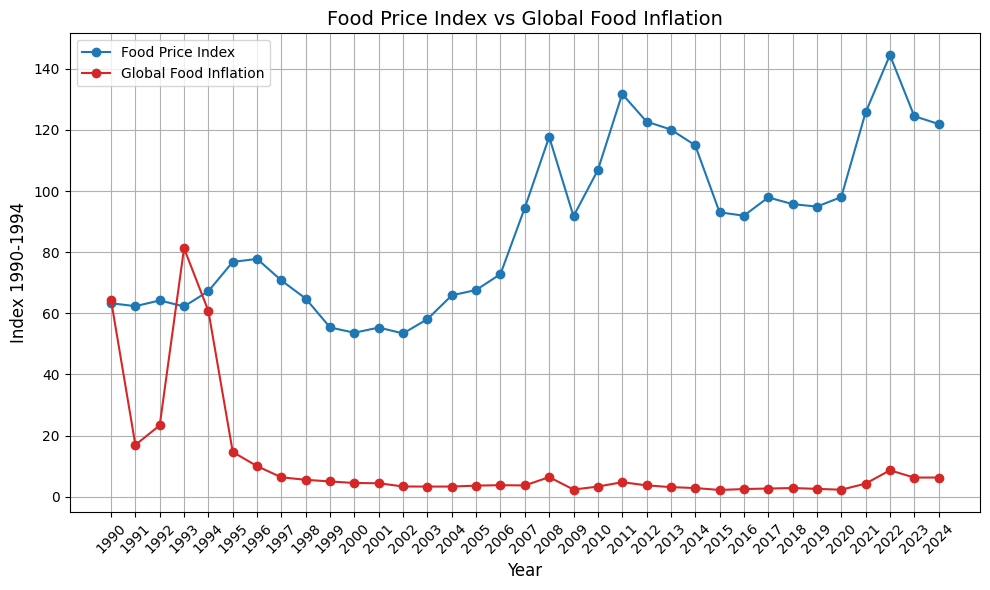

In [ ]:
# Plotting
plt.figure(figsize=(10,6))

# Convert 'year' column to integers before plotting if it contains floats
merged_df['year'] = merged_df['year'].astype(int)

# Plotting the Food Price Index and Global Food Inflation
plt.plot(merged_df['year'], merged_df['food_price_index'], label='Food Price Index', marker='o', color='tab:blue')
plt.plot(merged_df['year'], merged_df['Global_Food_Inflation'], label='Global Food Inflation', marker='o', color='tab:red')

# Adding titles and labels
plt.title('Food Price Index vs Global Food Inflation', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Index 1990-1994', fontsize=12)
plt.xticks(merged_df['year'], rotation=45)
plt.grid(True)

# Adding a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#it's in wide format, melt it
selected_categories = ['meat_index', 'dairy_index', 'cereals_index', 'oils_index', 'sugars_index']

if 'Category' not in merged_df.columns:
    df = merged_df.melt(id_vars='year',value_vars=selected_categories,var_name='Category', value_name='Inflation')

# Get unique categories
categories = df['Category'].unique()

# Create a trace for each category
fig = go.Figure()

for category in categories:
    cat_df = df[df['Category'] == category]
    fig.add_trace(go.Scatter(
        x=cat_df['year'],
        y=cat_df['Inflation'],
        mode='lines+markers',
        name=category,
        visible=True  # initially all are visible
    ))

# Create buttons for dropdown
buttons = []
for i, category in enumerate(categories):
    visibility = [False]*len(categories)
    visibility[i] = True
    buttons.append(dict(
        label=category,
        method="update",
        args=[{"visible": visibility},
              {"title": f"Food Inflation Trend: {category}"}]
    ))

# Add an "All" option
buttons.insert(0, dict(
    label="All Categories",
    method="update",
    args=[{"visible": [True]*len(categories)},
          {"title": "Food Inflation Trend: All Categories"}]
))

# Update layout with dropdown
fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        direction="down",
        showactive=True,
        x=1.1,
        y=1.2
    )],
    title="Food Inflation Trend: All Categories",
    xaxis_title="Year",
    yaxis_title="Inflation Rate (%) Index=2010=100",
    height=500
)

fig.show()

### 🧾 Historical Global Food Price Crises and Their Causes

#### 1. **2007–2008 Global Food Price Crisis**
**Causes:**
- **Biofuel Demand**: Increased diversion of crops like corn for ethanol production reduced food supply.
- **Oil Prices**: Rising energy costs elevated transportation and fertilizer expenses.
- **Speculation**: Financial speculation in commodity markets amplified price volatility.
- **Weather Events**: Droughts and floods in major producing regions affected yields.

> Sources: Wikipedia, WIRED

---

#### 2. **2010–2012 Price Surge**
**Causes:**
- **Climate Shocks**: Severe droughts in Russia and the U.S. impacted grain production.
- **Export Restrictions**: Countries imposed bans to secure domestic supply, tightening global markets.
- **Market Speculation**: Continued financial activities in commodity futures influenced prices.

---

#### 3. **2020–2022 Pandemic and Conflict-Induced Spike**
**Causes:**
- **COVID-19 Pandemic**: Disruptions in labor, logistics, and production led to supply shortages.
- **Russia-Ukraine War**: Both countries are significant exporters of wheat and sunflower oil; the conflict disrupted these exports.
- **Fertilizer Shortages**: Sanctions and supply chain issues led to reduced fertilizer availability, impacting crop production.
- **Climate Change**: Extreme weather events, such as droughts and floods, affected agricultural outputs globally.


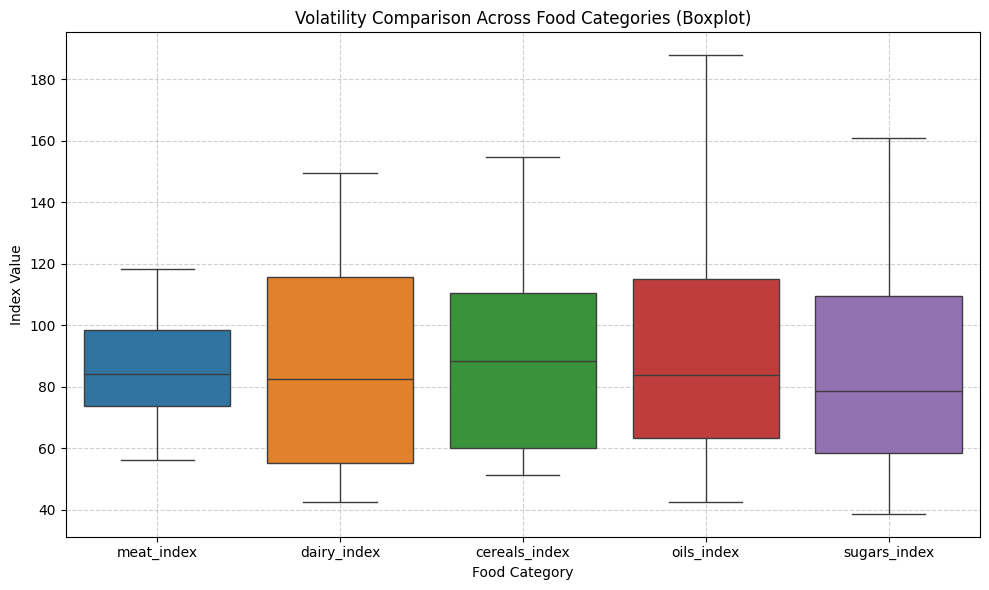

In [ ]:
# Filter out only food category indices
category_columns = ["meat_index", "dairy_index", "cereals_index", "oils_index", "sugars_index"]
category_data = merged_df[category_columns].dropna()

# Create boxplots to compare volatility
plt.figure(figsize=(10, 6))
sns.boxplot(data=category_data)
plt.title("Volatility Comparison Across Food Categories (Boxplot)")
plt.ylabel("Index Value")
plt.xlabel("Food Category")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### 📦 Boxplot Interpretation: Food Price Index Components

#### ✅ Observations:

- **🥥 Oils Index** shows the **highest volatility**  
  → Widest spread and high outliers  
  → Reflects sensitivity to **biofuel demand, war, weather**

- **🧀 Dairy** and **🍬 Sugar Indexes** show **high spread**  
  → Volatile due to **perishability** and **import/export dependencies**

- **🌾 Cereals Index** is **moderately volatile**  
  → Influenced by global supply (e.g., **wheat from Russia/Ukraine**)

- **🥩 Meat Index** has the **lowest volatility**  
  → Likely due to **stable demand** and **regulated pricing**


In [ ]:
# Computing Descriptive Statistics
nominal_real_stats = merged_df[['nominal_index', 'real_index']].describe()
inflation_stats = merged_df[['Global_Food_Inflation']].describe()

# Print Key Findings
print("Nominal vs Real Food Price Index Statistics:")
print(nominal_real_stats)
print("\nInflation Rate Statistics:")
print(inflation_stats)


Nominal vs Real Food Price Index Statistics:
       nominal_index  real_index
count      35.000000   35.000000
mean       88.028408   92.775064
std        26.653299   18.712575
min        53.432698   67.477205
25%        64.524662   77.087731
50%        91.787853   94.051055
75%       110.928596  106.600776
max       144.509866  141.390951

Inflation Rate Statistics:
       Global_Food_Inflation
count              35.000000
mean               11.013096
std                18.693280
min                 2.209405
25%                 3.231876
50%                 4.290260
75%                 6.385648
max                81.295594


In [ ]:
# Create a simple line chart
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=merged_df['year'],
    y=merged_df['nominal_index'],
    mode='lines+markers',
    name='Nominal Index',
    line=dict(color='royalblue')
))

fig.add_trace(go.Scatter(
    x=merged_df['year'],
    y=merged_df['real_index'],
    mode='lines+markers',
    name='Real Index',
    line=dict(color='firebrick')
))

# Update layout for clarity
fig.update_layout(
    title='Nominal vs Real Food Price Index Over Time',
    xaxis_title='Year',
    yaxis_title='Index Value',
    template='plotly_white',
    legend=dict(x=0.01, y=0.99),
    height=500
)

fig.show()

### **Key Findings**

#### **1. Nominal vs. Real Food Price Index (FPI)**

| Statistic   | Nominal FPI | Real FPI |
| ----------- | ----------- | -------- |
| **Mean**    | 88.02       | 92.77    |
| **Std Dev** | 26.65       | 18.71    |
| **Min**     | 53.43       | 67.47    |
| **Max**     | 144.51      | 141.39   |

- **Nominal FPI has increased significantly**, reaching a peak of **144.5** in 2024.
- **Real FPI is more stable**, indicating that while food prices have risen, inflation-adjusted prices show a more controlled trend.

#### **2. Food Price Index (Category-Wise) Trends**

- The dataset covers **1990-2024 (35 years)** and includes five food categories.
- No duplicate FPI values per year, suggesting consistent year-to-year tracking.
- Categories exhibit different volatility patterns, with oils and sugars showing higher fluctuations.

## 📊 Nominal vs Real Food Price Index Over Time

This line chart compares:

- 🟦 **Nominal Food Price Index** – The raw index of food prices each year, not adjusted for inflation.
- 🟥 **Real Food Price Index** – The same index, but adjusted for inflation to reflect actual purchasing power.

---

### 🧠 What Does This Graph Show?

| Observation Type       | What to Look For                              | What It Might Mean                                                    |
|------------------------|-----------------------------------------------|------------------------------------------------------------------------|
| **Gap between lines**  | Nominal much lower than Real                  | High inflation – food costs were effectively higher than they appear. |
| **Divergence/Crossover** | Lines moving apart or crossing over time     | Possible global events or economic shocks.                            |
| **Trend over time**    | Both lines rising, falling, or diverging      | Shows long-term patterns in food cost and inflation-adjusted trends.  |

---

### 🔍 Example Insights

- **2008**: If the Real Index jumps higher than the Nominal, it may indicate the impact of the **global financial crisis** and rising inflation.
- **2020**: A sharp rise in both lines might reflect **COVID-19 pandemic** effects like supply chain disruptions and inflation.
- **2022**: Divergence could signal global instability, e.g., due to the **Russia-Ukraine conflict** affecting global food supply.

---

### 🧩 Why This Is Useful

Understanding the difference between nominal and real food prices helps:

- 🏛 **Policymakers** assess food affordability and plan subsidies.
- 📈 **Businesses** develop informed pricing and procurement strategies.
- 👥 **Consumers** grasp the true cost of living changes over time.

---

In [ ]:
GDP_over_the_years.rename(columns={"observation_date":"year"}, inplace=True)
GDP_over_the_years['year']=pd.to_datetime(GDP_over_the_years['year']).dt.year
GDP_over_the_years.head()

,year,GDP
0,2000,10002.179
1,2000,10247.720
2,2000,10318.165
3,2000,10435.744
4,2001,10470.231


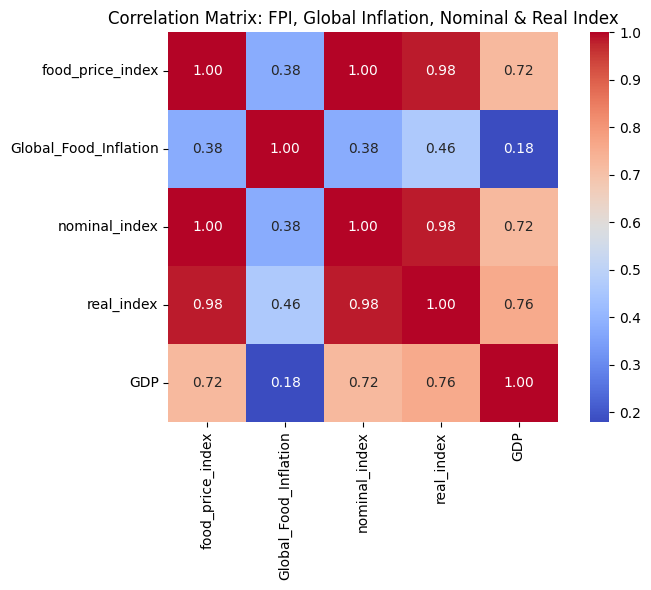

In [ ]:
correlation = merged_df.merge(GDP_over_the_years, on="year", how="inner")
reduced_data = correlation.drop(columns=[
    "year", "meat_index", "dairy_index", "cereals_index", "oils_index", "sugars_index"
]).dropna()

# Compute reduced correlation matrix
reduced_corr_matrix = reduced_data.corr()

# Plot the updated heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(reduced_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix: FPI, Global Inflation, Nominal & Real Index")
plt.tight_layout()
plt.show()

### 📊 Correlation Insights: FPI, CPI & GDP

#### 1. **FPI vs CPI (Global Food Inflation)** → **0.38**
✅ **Moderate positive correlation**  
This means **FPI and CPI do not move in perfect sync**.

**Why?**
- Government subsidies or food price controls  
- Local distribution issues or taxes  
- Different food consumption baskets

🔎 **Implication**:  
Global food price trends (**FPI**) don’t fully pass through to local inflation (**CPI**), especially in countries with **price interventions**.

---

#### 2. **FPI vs GDP** → **0.72**
✅ **Strong positive correlation**  
As **FPI increases**, **GDP also tends to increase**.

**Why?**
- Rising food prices may reflect economic demand in growing economies  
- Inflation in general boosts nominal GDP  
- Higher GDP countries face higher food costs due to richer diets or imports

🔎 **Implication**:  
**Richer or growing economies** often face **rising food prices**, but can **afford them better** — though the **affordability gap remains** for poorer regions.

---

#### 3. **CPI vs GDP** → **0.18**
⚠️ **Weak correlation**  
Global food inflation does not reliably track GDP growth.

**Why?**
- Inflationary pressure may hit **low-income countries harder**  
- CPI can spike even when **GDP remains low**

🔎 **Implication**:  
**CPI inflation**, especially for food, may **disproportionately affect low- and middle-income economies**, and is **not always linked** to economic output.


In [ ]:
# Make sure it's sorted by year
merged_df = merged_df.sort_values(by='year')
# Calculate YoY % change in Global Food Inflation
merged_df['Inflation_Change_Percent'] = abs(merged_df['Global_Food_Inflation'].pct_change()*10)
merged_df.to_csv("change_food_price_inflation_data.csv", index=False)
# Filter only the target years
target_years = [2008, 2011, 2022]
df_changes = merged_df[merged_df['year'].isin(target_years)][['year', 'Global_Food_Inflation', 'Inflation_Change_Percent']]

print(df_changes)

    year  Global_Food_Inflation  Inflation_Change_Percent
18  2008               6.419012                  7.368320
21  2011               4.759255                  4.349619
32  2022               8.644738                 10.149687


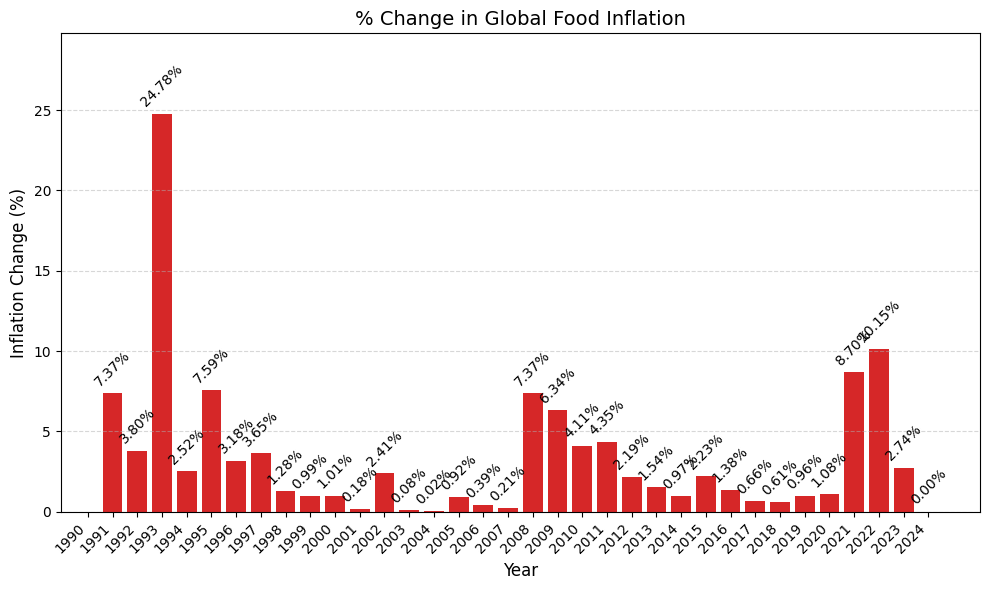

In [ ]:
plt.figure(figsize=(10, 6))

# Create the bar chart
bars = plt.bar(
    merged_df['year'].astype(str),
    merged_df['Inflation_Change_Percent'],
    color=['#d62728']
)

# Add data labels on top of bars with rotation
for bar in bars:
    height = bar.get_height()
    plt.annotate(
        f'{height:.2f}%',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # Slight offset for the text
        textcoords="offset points",
        ha='center',
        va='bottom',
        fontsize=10,  # Adjust font size for readability
        rotation=45    # Rotate the label by 45 degrees
    )

# Handle NaN values in 'Inflation_Change_Percent' by replacing them with 0
merged_df['Inflation_Change_Percent'] = merged_df['Inflation_Change_Percent'].fillna(0)

# Set the maximum y-limit for better visualization
plt.ylim(0, max(merged_df['Inflation_Change_Percent']) + 5)

# Titles and labels
plt.title('% Change in Global Food Inflation', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Inflation Change (%)', fontsize=12)

# Rotate the x-axis labels to avoid overlap
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add a grid to make the chart easier to read
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

#### 🟢 Normal Years
- Food inflation change ranges from **0% to 3%**.

#### 🔺 Crisis Years
- **2008**: Global food crisis → **7.4% inflation**
- **2010–2011**: Climate shocks, export bans → **~6%+**
- **2021–2022**: Pandemic + war → **8.7% and 10.1%**

#### 🌍 Impact
- Hardest on **low-income, import-dependent countries**
- Can strain **household budgets**, **subsidies**, and cause **social unrest**

---

> 📈 Food inflation usually stays between **0–3%**, but global shocks like **pandemics, wars, and droughts** can push it above **7–10%**, hurting the world’s most vulnerable populations the hardest.

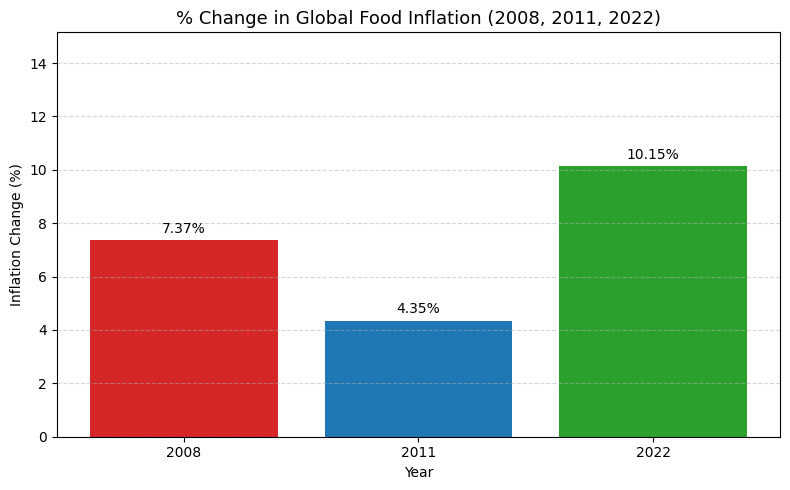

In [ ]:
plt.figure(figsize=(8, 5))
bars = plt.bar(
    df_changes['year'].astype(str),
    df_changes['Inflation_Change_Percent'],
    color=['#d62728', '#1f77b4', '#2ca02c']
)

# Add data labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Titles and labels
plt.title('% Change in Global Food Inflation (2008, 2011, 2022)', fontsize=13)
plt.xlabel('Year')
plt.ylabel('Inflation Change (%)')
plt.ylim(0, max(df_changes['Inflation_Change_Percent']) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

In [ ]:
! wget -q -O world_data.zip "https://github.com/sg2083/vis/raw/main/wb_countries.zip" # Updated URL
# Extract and load the shapefile
zip_ref = zipfile.ZipFile('world_data.zip', 'r')
zip_ref.extractall('World_Shape_Files')
# Load shapefile
WA0 = gpd.read_file('World_Shape_Files/WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp')
# WA0.to_csv('WA0.csv', index=False)

# WA0 = WA0[['OBJECTID', 'FORMAL_EN', 'POP_EST', 'POP_RANK', 'GDP_MD_EST',
#           'ECONOMY', 'INCOME_GRP', 'FIPS_10_',
#            'ISO_A2', 'ISO_N3', 'WB_A3',
#            'SUBREGION', 'REGION_WB', 'NAME_EN', 'WB_NAME', 'Shape_Leng',
#            'Shape_Area', 'geometry']]

In [ ]:
! wget -q -O general_inflation_url.csv "https://raw.githubusercontent.com/sg2083/vis/refs/heads/main/world_general_inflation.csv" # Updated URL


In [ ]:
general_inflation_data = pd.read_csv('general_inflation_url.csv')
general_inflation_data.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029
0,Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,5.6,7.8,10.6,-7.7,no data,no data,no data,no data,no data,no data
1,Albania,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,1.6,2,6.7,4.8,2.2,2.4,2.6,3,3,3
2,Algeria,9.7,14.6,6.6,7.8,6.3,10.4,14,5.9,5.9,...,2.4,7.2,9.3,9.3,5.3,5.2,4.5,4.7,4.4,4.4
3,Andorra,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,0.1,1.7,6.2,5.6,3.6,2.5,2,1.7,1.7,1.7
4,Angola,46.7,1.4,1.8,1.8,1.8,1.8,1.8,1.8,1.8,...,22.3,25.8,21.4,13.6,28.4,21.3,15.4,11.2,10,10


In [ ]:
# # Filter for sovereign countries and clean country names in WA0
# WA0 = WA0[WA0["TYPE"] == "Sovereign country"]
# WA0 = WA0[['WB_NAME', 'geometry']].rename(columns={'WB_NAME': 'Country'})
# WA0['Country'] = WA0['Country'].str.strip().str.lower()

# # Clean country names in inflation data
# general_inflation_data['Country'] = general_inflation_data['Country'].str.strip().str.lower()
# general_inflation_data['Country_clean'] = general_inflation_data['Country']

# # Perform fuzzy matching to align names
# wa0_country_names = WA0['Country'].unique()
# fuzzy_mapped = {}
# for country in general_inflation_data['Country_clean'].unique():
#     if country not in wa0_country_names:
#         best_match, score = process.extractOne(country, wa0_country_names)
#         if score >= 85:
#             fuzzy_mapped[country] = best_match

# # Apply fuzzy mappings
# general_inflation_data['Country_clean'] = general_inflation_data['Country_clean'].replace(fuzzy_mapped)

# # Convert all year columns to numeric up to 2023
#  years_to_keep = [col for col in general_inflation_data.columns if col.isdigit() and (int(col)>1999 and int(col) <= 2023)]
# for year in years_to_keep:
#     general_inflation_data[year] = pd.to_numeric(general_inflation_data[year], errors='coerce')

! wget -q -O general_inflation_url.csv "https://raw.githubusercontent.com/sg2083/vis/refs/heads/main/check.csv" # Updated URL
general_inflation_data= pd.read_csv('general_inflation_url.csv')
years_to_keep = [col for col in general_inflation_data.columns if col.isdigit() and (int(col)>1999 and int(col) <= 2023)]
general_inflation_data=general_inflation_data[['Country_clean'] + years_to_keep]
general_inflation_data.rename(columns={'Country_clean': 'Country'}, inplace=True)
merged_geometry_inflation=general_inflation_data
# # Merge the datasets
# merged_geometry_inflation = pd.merge(
#     WA0,
#     general_inflation_data[['Country_clean'] + years_to_keep],
#     left_on='Country',
#     right_on='Country_clean',
#     how='inner'
# ).drop(columns=['Country_clean'])

# Show the number of successfully merged countries
merged_geometry_inflation.head()


,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,afghanistan,NaN,NaN,5.1,35.7,16.4,10.6,6.8,8.7,26.4,...,4.7,-0.7,4.4,5.0,0.6,2.3,5.6,7.8,10.6,-7.7
1,albania,0.0,3.1,5.2,2.4,2.9,2.4,2.4,3.0,3.3,...,1.6,1.9,1.3,2.0,2.0,1.4,1.6,2.0,6.7,4.8
2,algeria,0.3,4.2,1.4,4.3,4.0,1.4,2.3,3.7,4.9,...,2.9,4.8,6.4,5.6,4.3,2.0,2.4,7.2,9.3,9.3
3,andorra,NaN,NaN,3.1,3.1,2.9,3.5,3.7,2.7,4.3,...,-0.1,-1.1,-0.4,2.6,1.0,0.5,0.1,1.7,6.2,5.6
4,angola,325.0,152.6,108.9,98.2,43.5,23.0,13.3,12.2,12.5,...,7.3,9.2,30.7,29.8,19.6,17.1,22.3,25.8,21.4,13.6


In [ ]:
! wget -q -O gdp.csv "https://raw.githubusercontent.com/sg2083/vis/refs/heads/main/gpd_for_3year.csv" # Updated URL
gdp_df= pd.read_csv('gdp.csv')
gdp_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,2008,2011,2021,2022,2023
0,Aruba,ABW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,38904.999250,35324.072060,35696.309370,41649.450790,44967.344510
1,Africa Eastern and Southern,AFE,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,3082.151418,3253.723505,3907.951637,4229.682100,4374.229532
2,Afghanistan,AFG,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,1333.747267,1744.060623,2144.166570,2122.995815,2211.280635
3,Africa Western and Central,AFW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,3185.418787,3620.649511,4698.926894,5107.272939,5343.468529
4,Angola,AGO,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,6651.377741,6711.390257,7408.126591,7924.888806,8040.702450


In [ ]:
gdp_df = gdp_df.rename(columns={"Country Name": "Country"})
gdp_df['Country'] = gdp_df['Country'].str.strip().str.lower()

# Keep only necessary columns: Country + year values
gdp_years = ['2008', '2011', '2021', '2022', '2023']
gdp_df = gdp_df[['Country'] + gdp_years]

# Rename year columns to 'gdp_YYYY'
gdp_df.columns = ['Country'] + [f"gdp_{year}" for year in gdp_years]

# Clean merged inflation data country names
merged_geometry_inflation['Country'] = merged_geometry_inflation['Country'].str.strip().str.lower()


gdp_country_names = gdp_df['Country'].unique()
merged_countries = merged_geometry_inflation['Country'].unique()

# Build fuzzy mapping
gdp_fuzzy_mapped = {}
for country in gdp_country_names:
    if country not in merged_countries:
        best_match, score = process.extractOne(country, merged_countries)
        if score >= 90:
            gdp_fuzzy_mapped[country] = best_match

# Apply fuzzy mappings
gdp_df['Country_clean'] = gdp_df['Country'].replace(gdp_fuzzy_mapped)

# Merge on corrected country names
merged_with_gdp_fuzzy = pd.merge(
    merged_geometry_inflation,
    gdp_df.drop(columns=["Country"]).rename(columns={"Country_clean": "Country"}),
    on="Country",
    how="inner"
)
# Output final dataset shape after fuzzy GDP match
merged_with_gdp_fuzzy.head()

,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2019,2020,2021,2022,2023,gdp_2008,gdp_2011,gdp_2021,gdp_2022,gdp_2023
0,afghanistan,NaN,NaN,5.1,35.7,16.4,10.6,6.8,8.7,26.4,...,2.3,5.6,7.8,10.6,-7.7,1333.747267,1744.060623,2144.166570,2122.995815,2211.280635
1,albania,0.0,3.1,5.2,2.4,2.9,2.4,2.4,3.0,3.3,...,1.4,1.6,2.0,6.7,4.8,8228.342590,10207.725970,16127.753260,19446.236660,21263.195660
2,algeria,0.3,4.2,1.4,4.3,4.0,1.4,2.3,3.7,4.9,...,2.0,2.4,7.2,9.3,9.3,13666.218200,14639.877940,14496.865470,15836.094440,16824.487900
3,andorra,NaN,NaN,3.1,3.1,2.9,3.5,3.7,2.7,4.3,...,0.5,0.1,1.7,6.2,5.6,44838.995000,46436.115860,59332.202910,68470.075950,71730.668680
4,angola,325.0,152.6,108.9,98.2,43.5,23.0,13.3,12.2,12.5,...,17.1,22.3,25.8,21.4,13.6,6651.377741,6711.390257,7408.126591,7924.888806,8040.702450


In [ ]:
merged_with_gdp_fuzzy.to_csv("merged_with_gdp_fuzzy.csv", index=False)

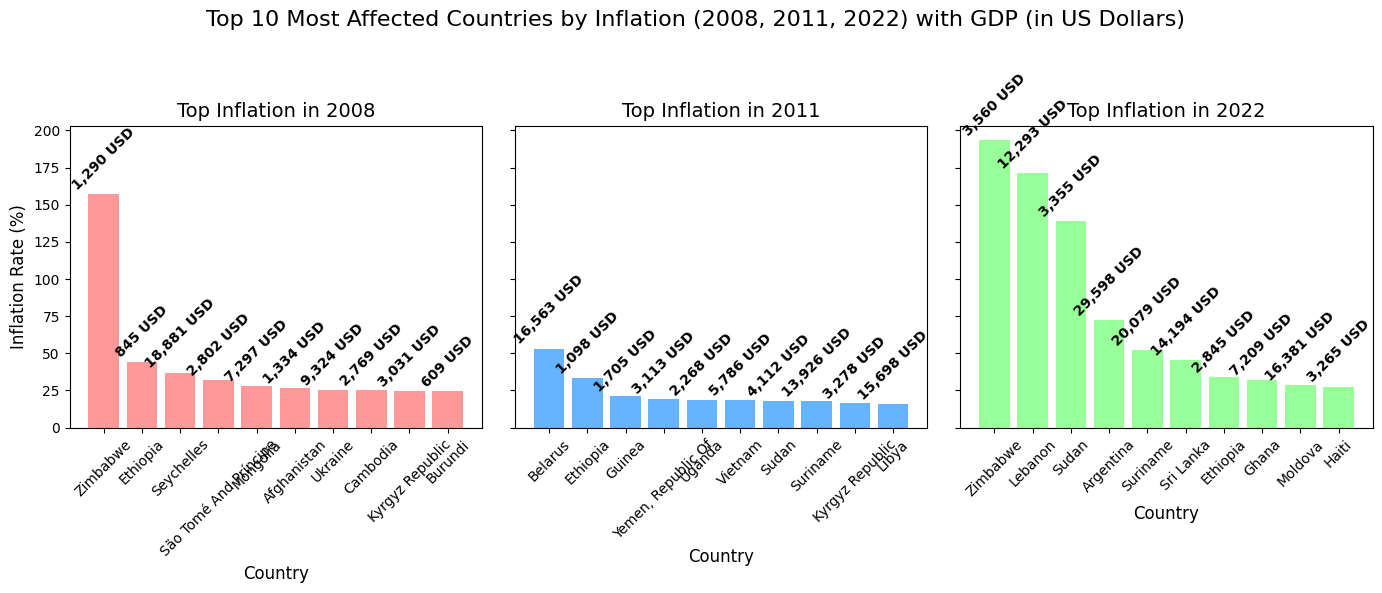

In [ ]:
merged_with_gdp_fuzzy['Country'] = merged_with_gdp_fuzzy['Country'].str.title()

inflation_years = ['2008', '2011', '2022']
gdp_years = ['gdp_2008', 'gdp_2011', 'gdp_2022']
colors = ['#ff9999', '#66b3ff', '#99ff99']

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharey=True)

for i, (inf_year, gdp_year, color) in enumerate(zip(inflation_years, gdp_years, colors)):
    top_data = merged_with_gdp_fuzzy[['Country', inf_year, gdp_year]].dropna()
    top_data = top_data.sort_values(by=inf_year, ascending=False).head(10)

    bars = axes[i].bar(top_data['Country'], top_data[inf_year], color=color)
    axes[i].set_title(f"Top Inflation in {inf_year}", fontsize=14)
    axes[i].set_xlabel("Country", fontsize=12)
    if i == 0:
        axes[i].set_ylabel("Inflation Rate (%)", fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

    # Add clearer GDP labels with spacing
    for bar, gdp in zip(bars, top_data[gdp_year]):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height + 1, f'{gdp:,.0f} USD',
                     ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=45)

# Title and layout
fig.suptitle("Top 10 Most Affected Countries by Inflation (2008, 2011, 2022) with GDP (in US Dollars)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 📈 Inflation & GDP in Crisis Years

#### 🔴 2008 – Global Financial Crisis
- **Zimbabwe** faced **extreme hyperinflation (>150%)**, with **GDP per capita only $1,290** – a classic case of economic collapse.
- Most other countries — **Ethiopia, Seychelles, São Tomé, Mongolia, Afghanistan** — had inflation between **25% and 55%**, and **GDPs under $10,000**.
- **High inflation** was concentrated in **low-income, fragile states** affected by **commodity price shocks** and **poor fiscal control**.

---

#### 🔵 2011 – Food & Commodity Shock
- **Belarus, Ethiopia, and Guinea** experienced the highest inflation (**30–40%**), with **very low GDPs**, indicating **vulnerability to external shocks**.
- **Vietnam and Sudan** also appear, showing how **emerging economies** were hit hard by **global food price spikes**.
- The pattern persists: **low-income or politically unstable countries** are **more prone to inflation** during global shocks.

---

#### 🟢 2022 – Post-Pandemic & War Disruption
- **Zimbabwe** resurfaces with ~**200% inflation**, but **GDP rises slightly to $3,560** — still very low.
- **Lebanon, Sudan, Argentina, and Sri Lanka** faced inflation **above 50%**, tied to **currency collapse, political crises, or war**.
- **Ghana, Moldova, and Haiti** also appear, reinforcing the trend: **lower GDP countries are more vulnerable** during crises.

---

- **Hyperinflation** remains a **developing-country issue** — all high-inflation countries have **low to mid-level GDPs**.
- **Zimbabwe** appears in every crisis year, reflecting **persistent structural economic problems**.
- Inflation spikes in countries facing:
  - 🪖 **War** (e.g., Sudan, Ukraine, Libya)  
  - 💸 **Currency collapse** (e.g., Lebanon, Argentina)  
  - 🏛️ **Fragile institutions & fiscal mismanagement**
- Countries with **GDP < $5,000** tend to **dominate the most-affected list** across all years.


In [ ]:
verified_2011_updates = {
    "nauru": 0.3,
}

# Standardize country names in the dataset
merged_with_gdp_fuzzy['Country_clean'] = merged_with_gdp_fuzzy['Country'].str.strip().str.lower()

# Update 2011 inflation values with verified data
for country, new_value in verified_2011_updates.items():
    merged_with_gdp_fuzzy.loc[merged_with_gdp_fuzzy['Country_clean'] == country, '2011'] = new_value

# Confirm the updates
merged_with_gdp_fuzzy[['Country', '2011']][merged_with_gdp_fuzzy['Country_clean'].isin(verified_2011_updates.keys())]

,Country,2011
116,Nauru,0.3


In [ ]:
colors = ['#a1dab4', '#41b6c4', '#2c7fb8']

# Create side-by-side plots for least affected countries
# Prepare data
combined_data = pd.DataFrame()

for inf_year, gdp_year in zip(inflation_years, gdp_years):
    bottom_data = merged_with_gdp_fuzzy[['Country', inf_year, gdp_year]].dropna()
    bottom_data = bottom_data.sort_values(by=inf_year).head(10).copy()
    bottom_data['Inflation_Year'] = inf_year
    bottom_data['Inflation'] = bottom_data[inf_year]
    bottom_data['GDP'] = bottom_data[gdp_year]
    combined_data = pd.concat([combined_data, bottom_data[['Country', 'Inflation_Year', 'Inflation', 'GDP']]])

# Plot interactive grouped bar chart
fig = px.bar(
    combined_data,
    x='Country',
    y='Inflation',
    color='Inflation_Year',
    barmode='group',
    hover_data={'GDP': ':.0f', 'Inflation': ':.2f'},
    title="Top 10 Least Affected Countries by Inflation (2008, 2011, 2022) with GDP (USD)",
    labels={'Inflation': 'Inflation Rate (%)'},
    height=600
)

fig.update_layout(xaxis_tickangle=-30)
fig.show()

### 📅 Year-by-Year Global Inflation Resilience

#### 🟦 2008 (Global Financial Crisis)
Countries like **Ireland, Germany, Portugal, Iraq, Switzerland, and Canada** had very low inflation rates (**2%–3%**).

**Likely Reasons:**
- Strong fiscal institutions  
- Stable food import systems  
- Government subsidies or price controls  

---

#### 🟥 2011 (Food Price Crisis)
Several small or oil-rich nations — **Bahrain, Tuvalu, UAE, Vanuatu, Morocco** — showed low or even negative inflation.  
**Japan** had **deflation**, consistent with its long-term trend.

**Likely Reasons:**
- Oil revenue cushioning effects  
- Strong currency and import dependency (especially Japan)  

---

#### 🟩 2022 (Pandemic Recovery + Ukraine War)
Countries like **Saudi Arabia, Oman, Seychelles, Grenada, Maldives, and Saint Kitts and Nevis** had relatively low inflation (~**2.5%–2.7%**) despite global shocks.

**Possible Explanations:**
- Controlled energy prices (especially Gulf countries)  
- Smaller island economies with unique import structures or monetary policies  

---

### 🧠 Insights and Takeaways

- 🌍 **Inflation resilience** is not limited to large economies — small nations like **Tuvalu** and **Seychelles** also showed stability.  
- 🛢️ **Oil-producing countries** (UAE, Saudi Arabia, Oman) often shield their economies through **subsidized fuel and food**.  
- 🇯🇵 **Japan’s low inflation** reflects a consistent **deflationary trend**.  
- 💡 Countries with **strong monetary controls**, **food subsidies**, or **low import dependence** are better protected from global inflation shocks.  


In [ ]:
! wget -q -O Food_CPI.csv "https://raw.githubusercontent.com/sg2083/vis/refs/heads/main/Food_CPI.csv" # Updated URL
food_cpi_df = pd.read_csv("Food_CPI.csv", encoding='ISO-8859-1')
food_cpi_df.head()

,COUNTRY,INDEX_TYPE,COICOP_1999,TYPE_OF_TRANSFORMATION,FREQUENCY,SCALE,2008,2011,2022
0,Afghanistan,Consumer price index (CPI),Food and non-alcoholic beverages,Index,Annual,Units,87.603105,83.769862,161.394591
1,Albania,Consumer price index (CPI),Food and non-alcoholic beverages,Index,Annual,Units,65.650000,75.608025,117.279379
2,Algeria,Consumer price index (CPI),Food and non-alcoholic beverages,Index,Annual,Units,128.395000,150.962500,265.576667
3,Angola,Consumer price index (CPI),Food and non-alcoholic beverages,Index,Annual,Units,NaN,NaN,145.366072
4,Antigua and Barbuda,Consumer price index (CPI),Food and non-alcoholic beverages,Index,Annual,Units,NaN,NaN,115.485000


In [ ]:
# Keep only the necessary columns
food_cpi_df = food_cpi_df[['COUNTRY', '2008', '2011', '2022']].copy()

# Standardize column names and country names
food_cpi_df.rename(columns={'COUNTRY': 'Country', '2008': 'cpi_2008', '2011': 'cpi_2011', '2022': 'cpi_2022'}, inplace=True)
food_cpi_df['Country'] = food_cpi_df['Country'].str.strip().str.lower()

# Also standardize the main merged dataset
merged_with_gdp_fuzzy['Country'] = merged_with_gdp_fuzzy['Country'].str.strip().str.lower()

# Merge CPI with GDP + inflation dataset
merged_with_cpi = pd.merge(merged_with_gdp_fuzzy, food_cpi_df, on='Country', how='inner')

# Calculate affordability index for 2008, 2011, and 2022
for year in ['2008', '2011', '2022']:
    gdp_col = f'gdp_{year}'
    cpi_col = f'cpi_{year}'
    aff_col = f'affordability_index_{year}'
    if gdp_col in merged_with_cpi.columns and cpi_col in merged_with_cpi.columns:
        merged_with_cpi[aff_col] = merged_with_cpi[gdp_col] / merged_with_cpi[cpi_col]

# Show affordability results
affordability_cols = [col for col in merged_with_cpi.columns if col.startswith('affordability_index')]
merged_with_cpi[['Country'] + affordability_cols].head()

,Country,affordability_index_2008,affordability_index_2011,affordability_index_2022
0,afghanistan,15.224886,20.819667,13.154070
1,albania,125.336521,135.008499,165.811218
2,algeria,106.438866,96.976918,59.629088
3,angola,NaN,NaN,54.516771
4,antigua and barbuda,NaN,NaN,260.048902


In [ ]:
merged_with_cpi.to_csv("merged_with_cpi.csv", index=False)

In [ ]:
# Reshape
plot_df = merged_with_cpi[[
    "Country",
    "affordability_index_2008",
    "affordability_index_2011",
    "affordability_index_2022"
]]

plot_df_melted = plot_df.melt(
    id_vars="Country",
    value_vars=["affordability_index_2008", "affordability_index_2011", "affordability_index_2022"],
    var_name="Year",
    value_name="Affordability_Index"
)

plot_df_melted["Year"] = plot_df_melted["Year"].str.extract(r'(\d+)', expand=False)
plot_df_melted = plot_df_melted.dropna(subset=["Affordability_Index"])

# Plot
fig = px.choropleth(
    plot_df_melted,
    locations="Country",
    locationmode="country names",
    color="Affordability_Index",
    animation_frame="Year",
    hover_name="Country",
    color_continuous_scale="YlOrRd",
    range_color=(0, plot_df_melted["Affordability_Index"].max()),
    title="🌍 Food Affordability Index by Country (2008, 2011, 2022)"
)

fig.update_layout(geo=dict(showframe=False, showcoastlines=True))
fig.show()

https://impact.economist.com/sustainability/project/food-security-index/

#Case Studies
## Zimbabwe (2008) – Hyperinflation Crisis

**What Happened?**  
In 2008, Zimbabwe experienced one of the worst episodes of hyperinflation in history, with inflation rates exceeding **150,000%**.

**Causes:**
- Land reform policy collapse
- Decline in agricultural output
- Excessive money printing by the Reserve Bank
- Political instability and loss of investor confidence

**Impact:**
- Basic food items became unaffordable
- People resorted to barter and foreign currencies
- The Zimbabwe dollar was ultimately abandoned

##Venezuela (2016–2018) – Currency Collapse & Food Crisis

**What Happened?**  
Due to fiscal mismanagement, oil dependency, and political turmoil, Venezuela’s inflation soared above **100%** by 2018.

**Causes:**
- Oil price crash reduced national revenue
- Currency devaluation and black market reliance
- Government subsidies and price controls failed

**Impact:**
- Widespread food shortages
- Malnutrition and mass emigration
- U.S. sanctions exacerbated the crisis

##Ukraine (2022) – Global Wheat Supply Shock

**What Happened?**  
The Russian invasion of Ukraine disrupted wheat and fertilizer exports from two of the world's largest agricultural producers.

**Causes:**
- War blocked Black Sea ports
- Sanctions and logistics breakdown
- Fertilizer prices spiked due to gas shortages

**Impact:**
- Global food prices soared
- Major impact on import-dependent countries in Africa and the Middle East
- Triggered renewed focus on food security and supply chain resilience


